# Predicting fatality rates due to the novel Corona Virus

In [3]:
#Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler

In [123]:
#Reading in the datafiles
#
covid_indicators = pd.read_csv("./Datasets/inform-covid-indicators.csv")
#
gov_measures = pd.read_csv("./Datasets/acaps-covid-19-government-measures-dataset.csv")
#
daily_dashboard = pd.read_csv("./Datasets/johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv")
#
train = pd.read_csv("./Datasets/train.csv")
#
test = pd.read_csv("./Datasets/test.csv")
#Country Population File
country_population = pd.read_csv("./Datasets/Country_Population.csv")

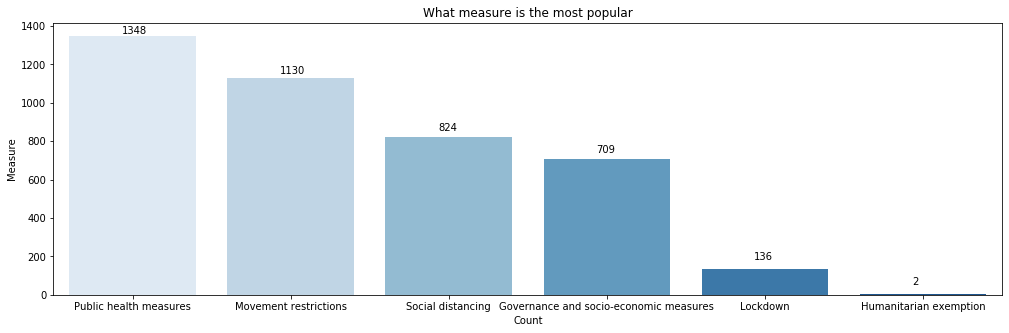

In [124]:
#Visualization
#What goverment measures are the most popular
gov_measure_by_category = gov_measures.groupby([gov_measures.category]).count()
gov_measure_by_category = gov_measure_by_category.sort_values(['id'], ascending=[False])
plt.figure(figsize=(17,5))
ax = sns.barplot(x
                 =gov_measure_by_category.index, y=gov_measure_by_category.id,  palette="Blues")
ax.set_title("What measure is the most popular")
ax.set_xlabel("Count")
ax.set_ylabel("Measure")
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + 0.30, p.get_height()/1.03),
                xytext=(5, 10), textcoords='offset points')
plt.show()

In [125]:
#World wide trend from Jan 22nd to April 7th
#Train data contains the number of Confirmed and Fatalities  and new cases in all countries
world_wide_trend = train.groupby(['Date'])[['ConfirmedCases', 'Fatalities']].sum()
world_wide_trend['NewCases'] = world_wide_trend['ConfirmedCases'] - world_wide_trend['ConfirmedCases'].shift(1)
world_wide_trend
world_wide_trend_melted = pd.melt(world_wide_trend.reset_index(), id_vars=['Date'], value_vars=['ConfirmedCases', 'Fatalities', 'NewCases'])
world_wide_trend_melted = world_wide_trend_melted.rename(columns = {"variable":"Measure"}) 

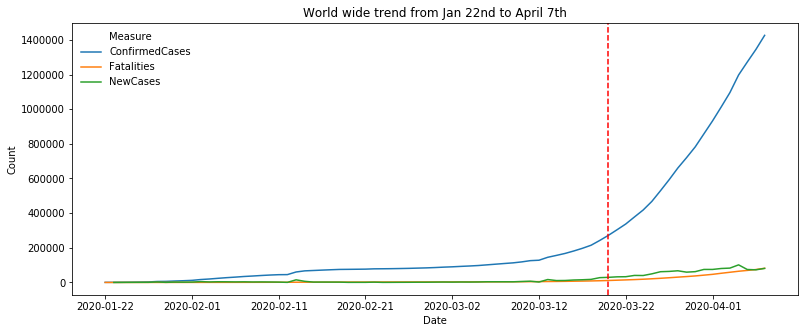

In [126]:
plt.figure(figsize=(13,5))
ax = sns.lineplot(x='Date', y='value', hue='Measure', data= world_wide_trend_melted)
ax.set_title("World wide trend from Jan 22nd to April 7th")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.axvline("2020-03-20", color="red", linestyle="--")
leg = ax.legend()
ax.legend(loc='upper left', frameon=False)
plt.show()

In [127]:
#World heat map confirmed cases
country = train.groupby(['Date','Country_Region'])[['ConfirmedCases', 'Fatalities']].sum().reset_index()
country_latest = country[country['Date'] =='2020-04-07'].reset_index()
country_latest['logConfirmed']= np.log(country_latest['ConfirmedCases'])


In [128]:
worldmap = px.choropleth(country_latest, locations="Country_Region", 
                    locationmode='country names', color="logConfirmed", 
                    hover_name="Country_Region", hover_data=["ConfirmedCases"],
                    range_color=[country_latest['logConfirmed'].min(), country_latest['logConfirmed'].max()], 
                    color_continuous_scale="blues",
                    title='Countries with Confirmed Cases')
worldmap.update_layout(showlegend=False)
worldmap.show()

In [129]:
#Top 15 countries with highest Fatalities
country_latest= country_latest.sort_values(['Fatalities'], ascending=[False])
top_mortality = country_latest.head(15)
top_mortality =top_mortality[['Country_Region','Fatalities']]
top_mortality =top_mortality.sort_values(['Fatalities'], ascending=[True])

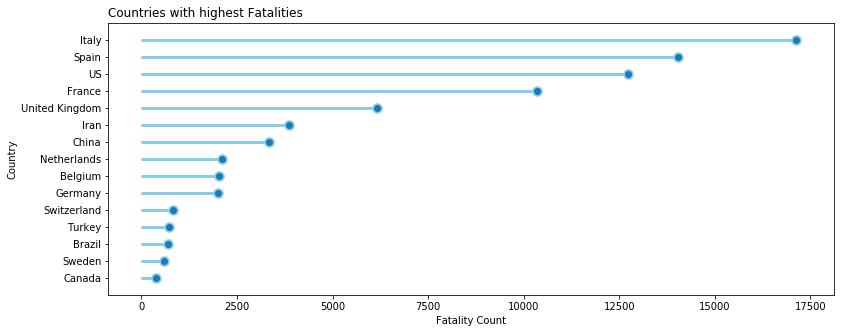

In [130]:
my_range=range(0,len(top_mortality['Fatalities']))
plt.figure(figsize=(13,5))
plt.hlines(y=top_mortality['Country_Region'], xmin=0, xmax=top_mortality['Fatalities'], color='skyblue', linewidth = 3)
plt.plot(top_mortality['Fatalities'], my_range, "o")
plt.scatter(top_mortality['Fatalities'], my_range, color='skyblue', s=90, alpha=1) 
# Add titles and axis names
plt.title("Countries with highest Fatalities", loc='left')
plt.xlabel('Fatality Count')
plt.ylabel('Country')
plt.show();


In [131]:
#Population density vs Confirmed Cases
density_confirmed = pd.merge(country_latest, covid_indicators, left_on='Country_Region', right_on="country")
density_confirmed = density_confirmed[['Country_Region','ConfirmedCases','population_density']]
density_confirmed['log_ConfirmedCases'] = np.log(density_confirmed['ConfirmedCases'])
density_confirmed['log_population_density'] = np.log(density_confirmed['population_density'])

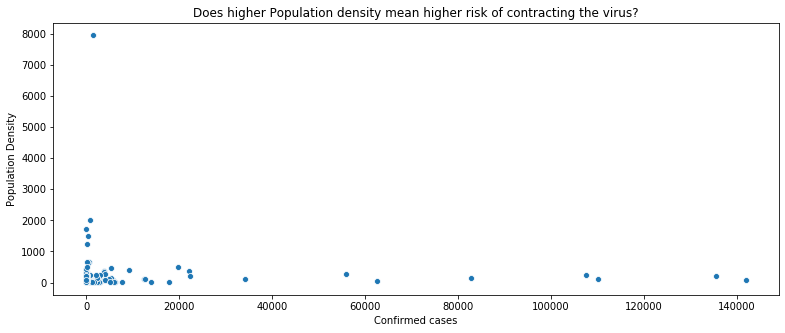

In [132]:
plt.figure(figsize=(13,5))
sns.scatterplot('ConfirmedCases', 'population_density',data=density_confirmed)
plt.title("Does higher Population density mean higher risk of contracting the virus?")
plt.xlabel("Confirmed cases")
plt.ylabel("Population Density")
#plt.ylim(0,750)
#plt.xlim(0,2000)
plt.show();

In [133]:
#daily_dashboard
covid_indicators
factors = pd.merge(daily_dashboard, covid_indicators, left_on='country_region', right_on="country")
factors.drop(['last_update','lat','long','active','country' ], axis=1, inplace=True)


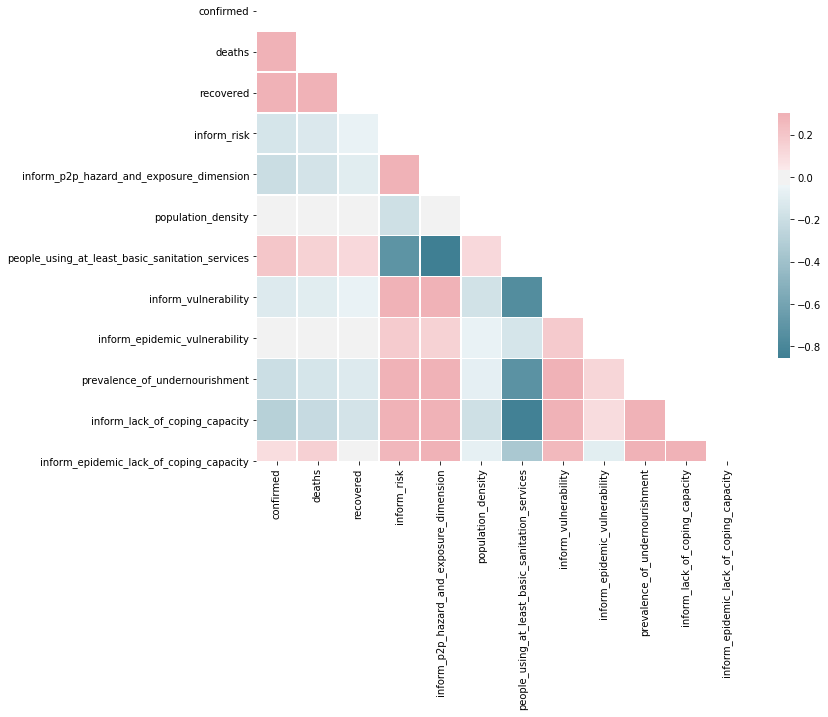

In [134]:
#Checking correlations

corr= factors.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

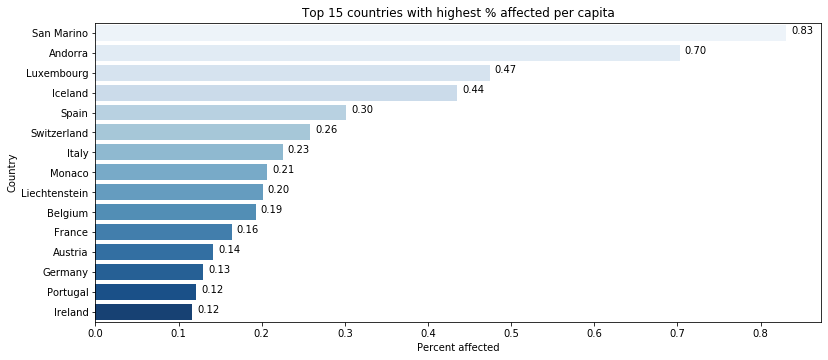

In [135]:
#Highest % affected Per capita
popvscc = pd.merge(country_latest, country_population , left_on='Country_Region', right_on="Countries")
popvscc.drop(['index','Date','Country_Region','logConfirmed'], axis=1, inplace=True)
popvscc['Population']= popvscc['Population'].str.replace(',', '')
popvscc['Population']= pd.to_numeric(popvscc['Population'])
popvscc['ccrate']= popvscc['ConfirmedCases'] /popvscc['Population']*100
popvscc= popvscc.sort_values(['ccrate'], ascending=[False])
popvscc_plot = popvscc.head(15)
plt.figure(figsize=(13,5.5))
ax = sns.barplot(x
                 = popvscc_plot.ccrate, y=popvscc_plot.Countries,  palette="Blues")
ax.set_title("Top 15 countries with highest % affected per capita")
ax.set_xlabel("Percent affected")
ax.set_ylabel("Country")
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.925),
                xytext=(5, 10), textcoords='offset points')
plt.show()